In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

In [2]:


download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/tribolium.zip',
    targetdir = 'data',
)



Files missing, downloading... extracting... done.

data:
- tribolium
- tribolium/test
- tribolium/test/GT
- tribolium/test/GT/nGFP_0.1_0.2_0.5_20_14_late.tif
- tribolium/test/low
- tribolium/test/low/nGFP_0.1_0.2_0.5_20_14_late.tif
- tribolium/train
- tribolium/train/GT
- tribolium/train/GT/nGFP_0.1_0.2_0.5_20_13_late.tif
- tribolium/train/low
- tribolium/train/low/nGFP_0.1_0.2_0.5_20_13_late.tif


image size = (48, 773, 665)


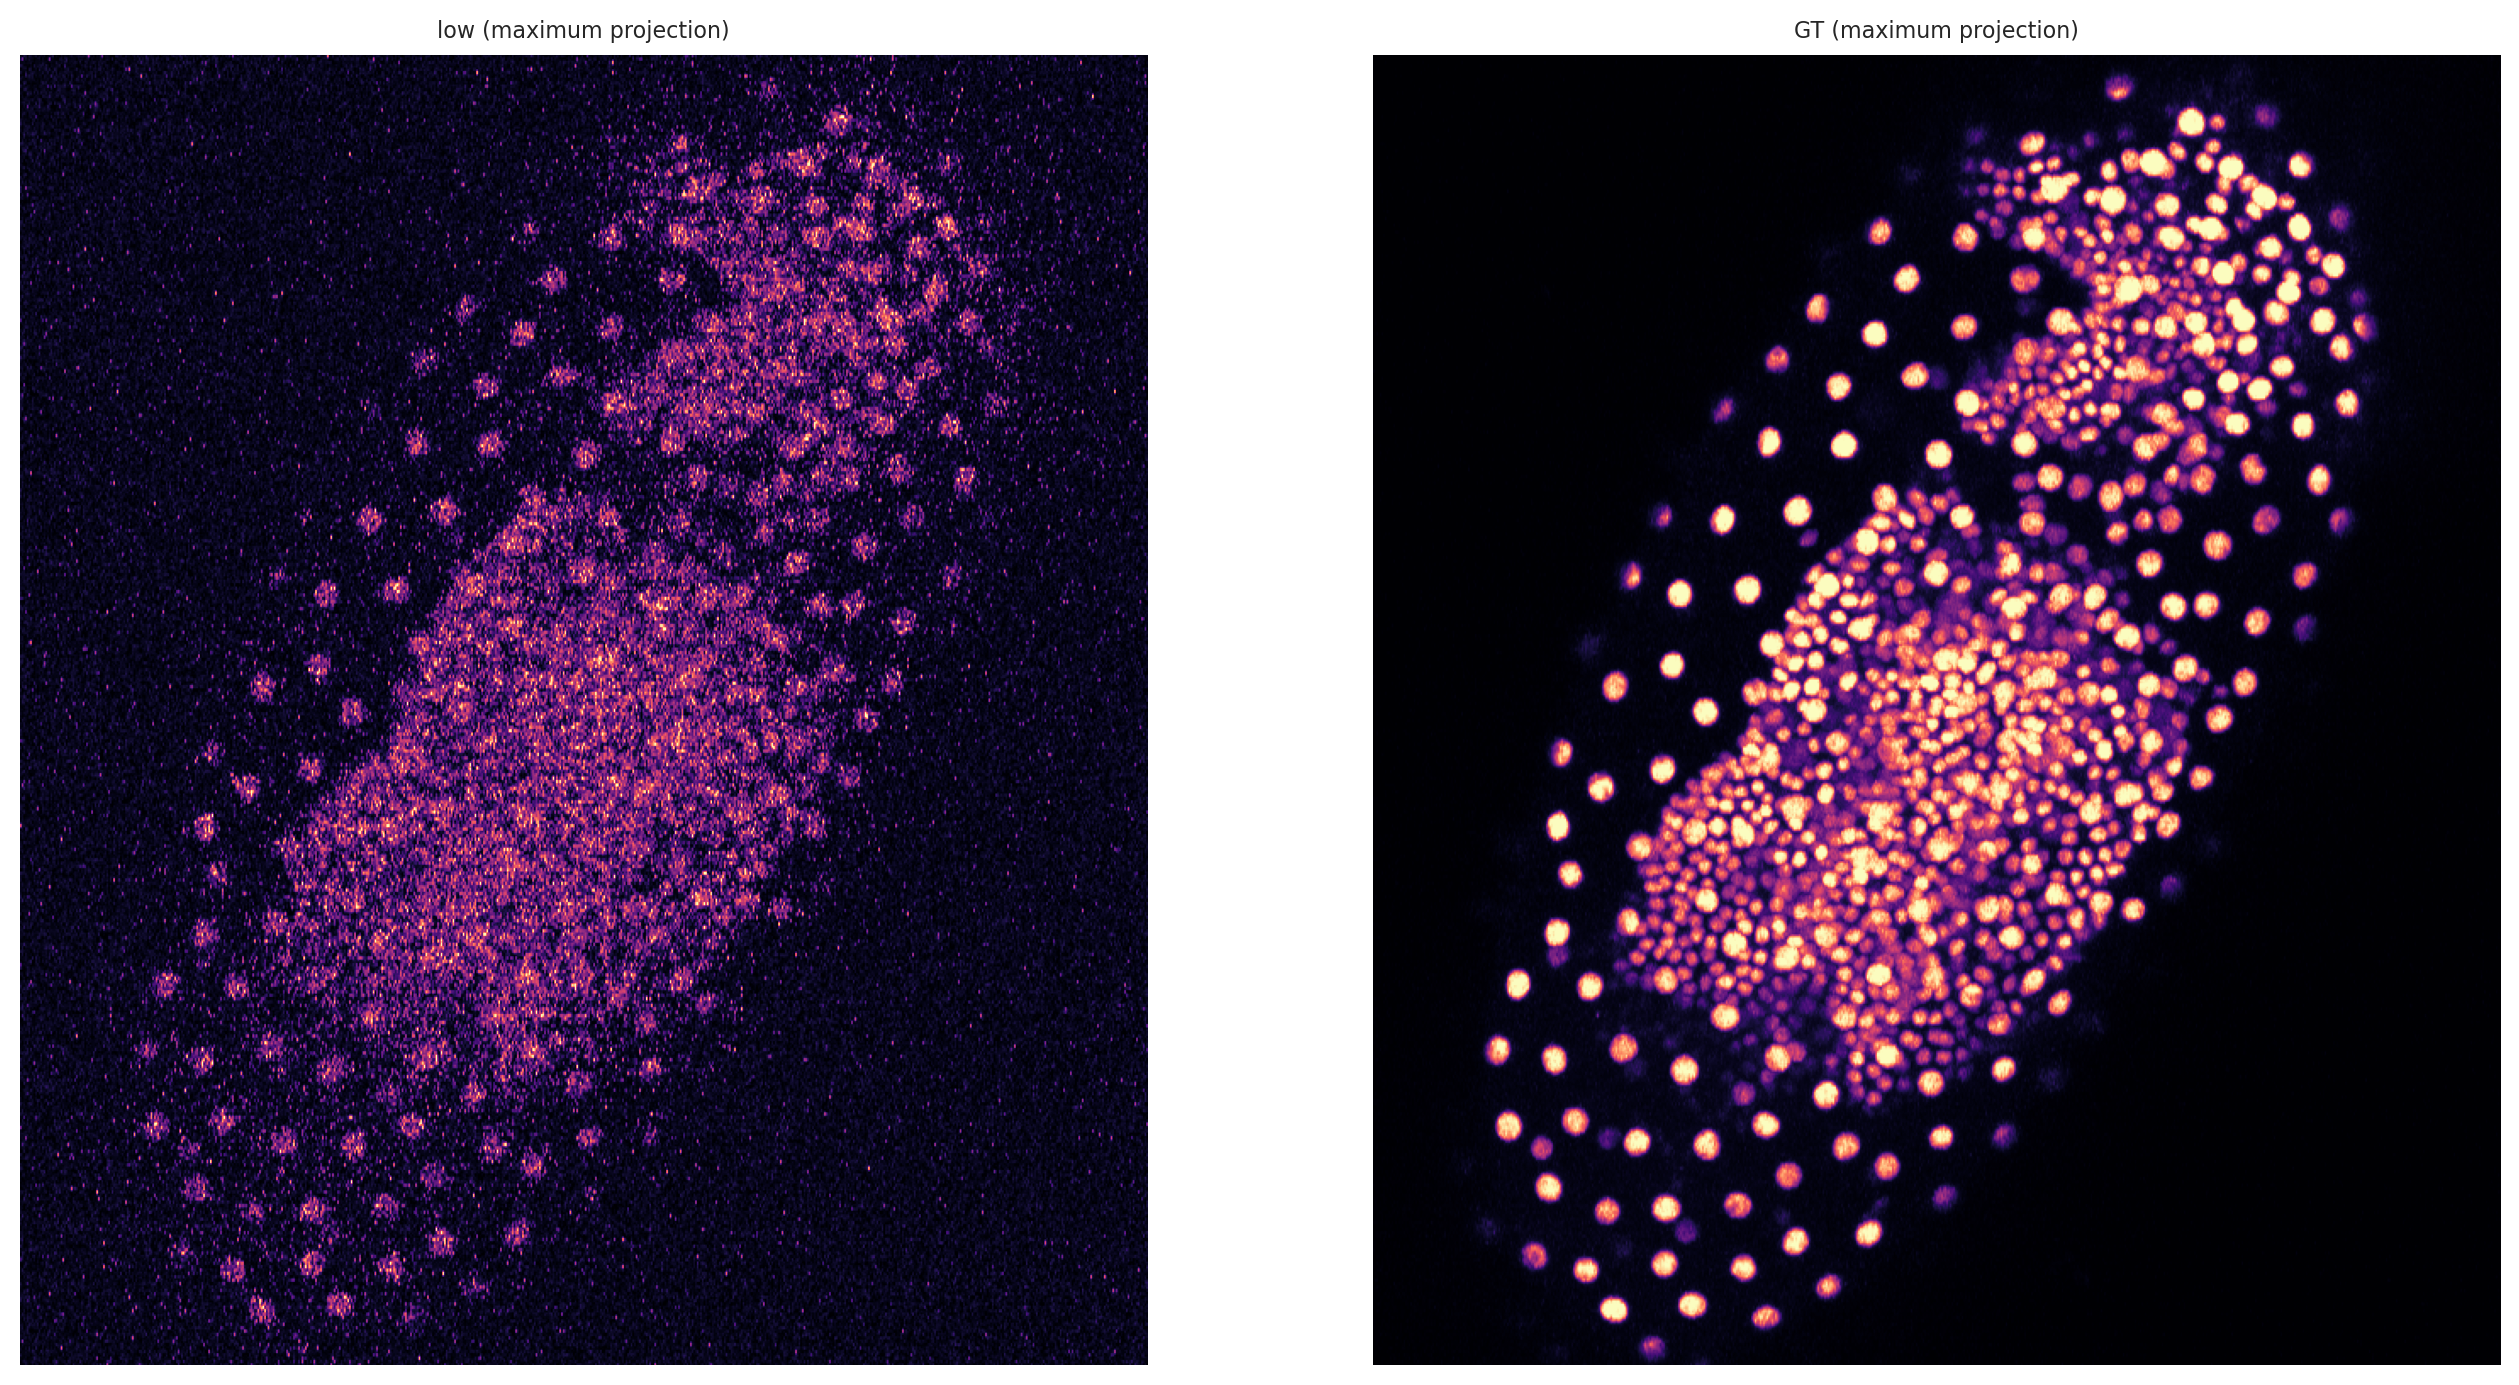

In [3]:
y = imread('data/tribolium/train/GT/nGFP_0.1_0.2_0.5_20_13_late.tif')
x = imread('data/tribolium/train/low/nGFP_0.1_0.2_0.5_20_13_late.tif')
print('image size =', x.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);

In [4]:
raw_data = RawData.from_folder (
    basepath    = 'data/tribolium/train',
    source_dirs = ['low'],
    target_dir  = 'GT',
    axes        = 'ZYX',
)

In [5]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (16,64,64),
    n_patches_per_image = 1024,
    save_file           = 'data/my_training_data.npz',
)

    1 raw images x    1 transformations   =     1 images
    1 images     x 1024 patches per image =  1024 patches in total
Input data:
data/tribolium/train: target='GT', sources=['low'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
16 x 64 x 64


100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


Saving data to data/my_training_data.npz.


In [6]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (1024, 1, 16, 64, 64)
axes  of X,Y = SCZYX


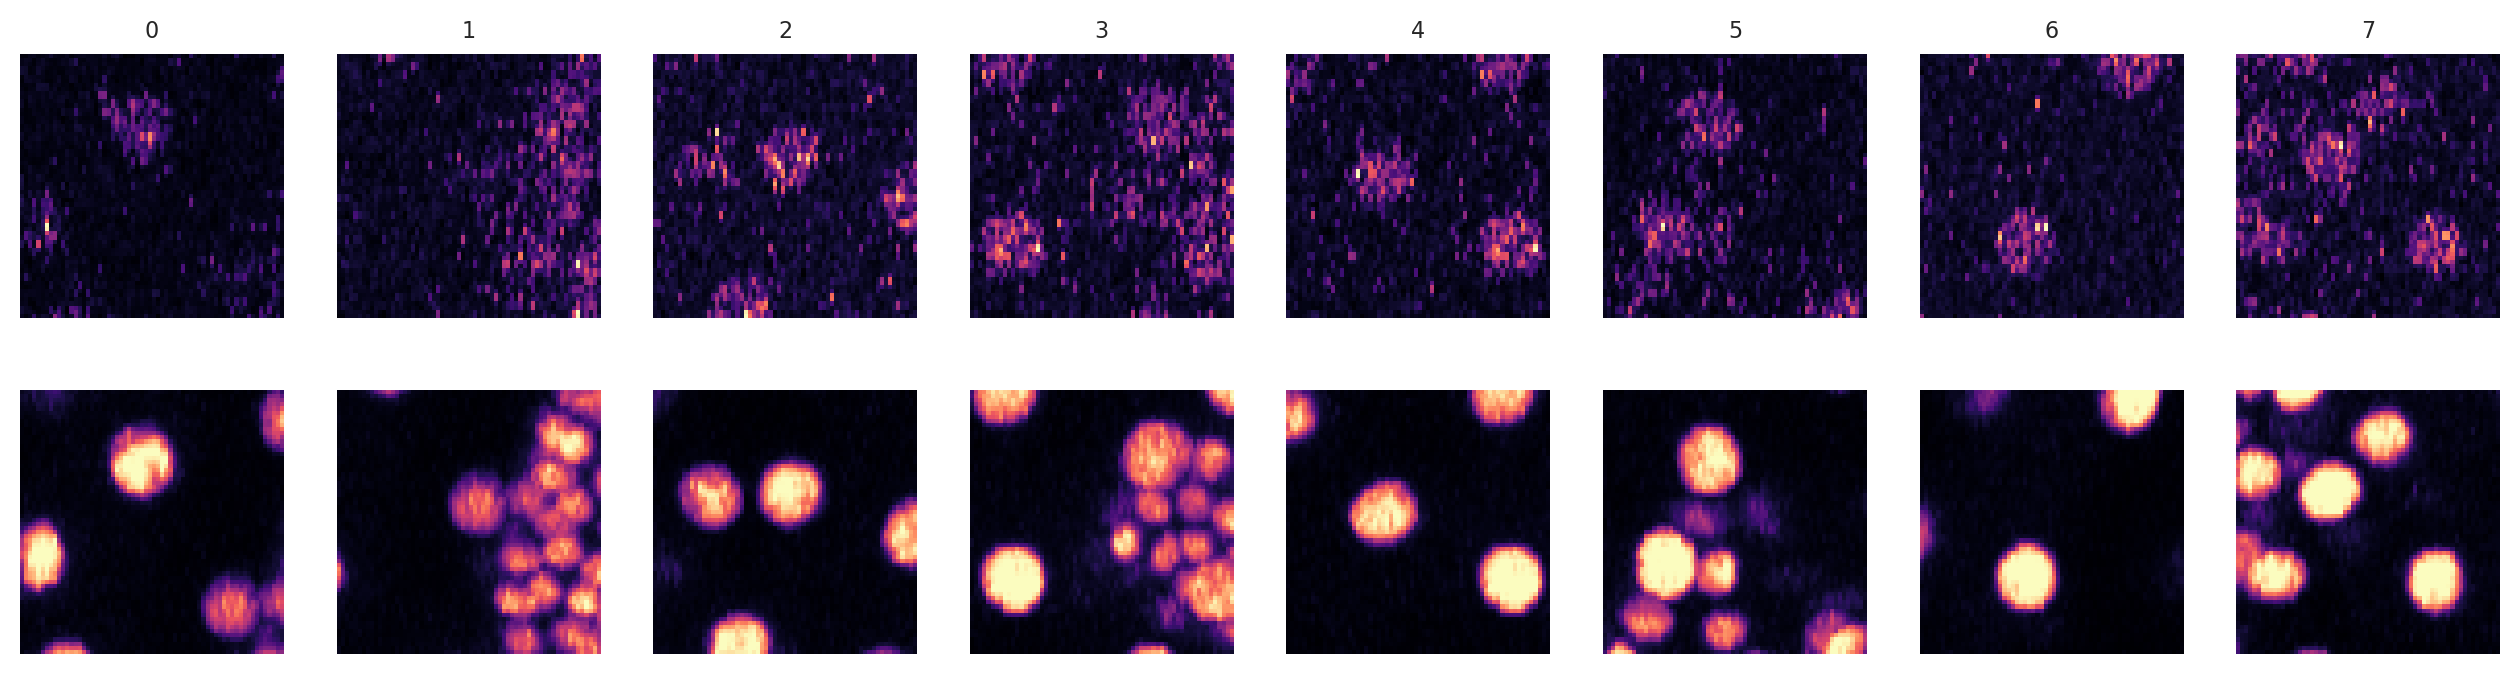

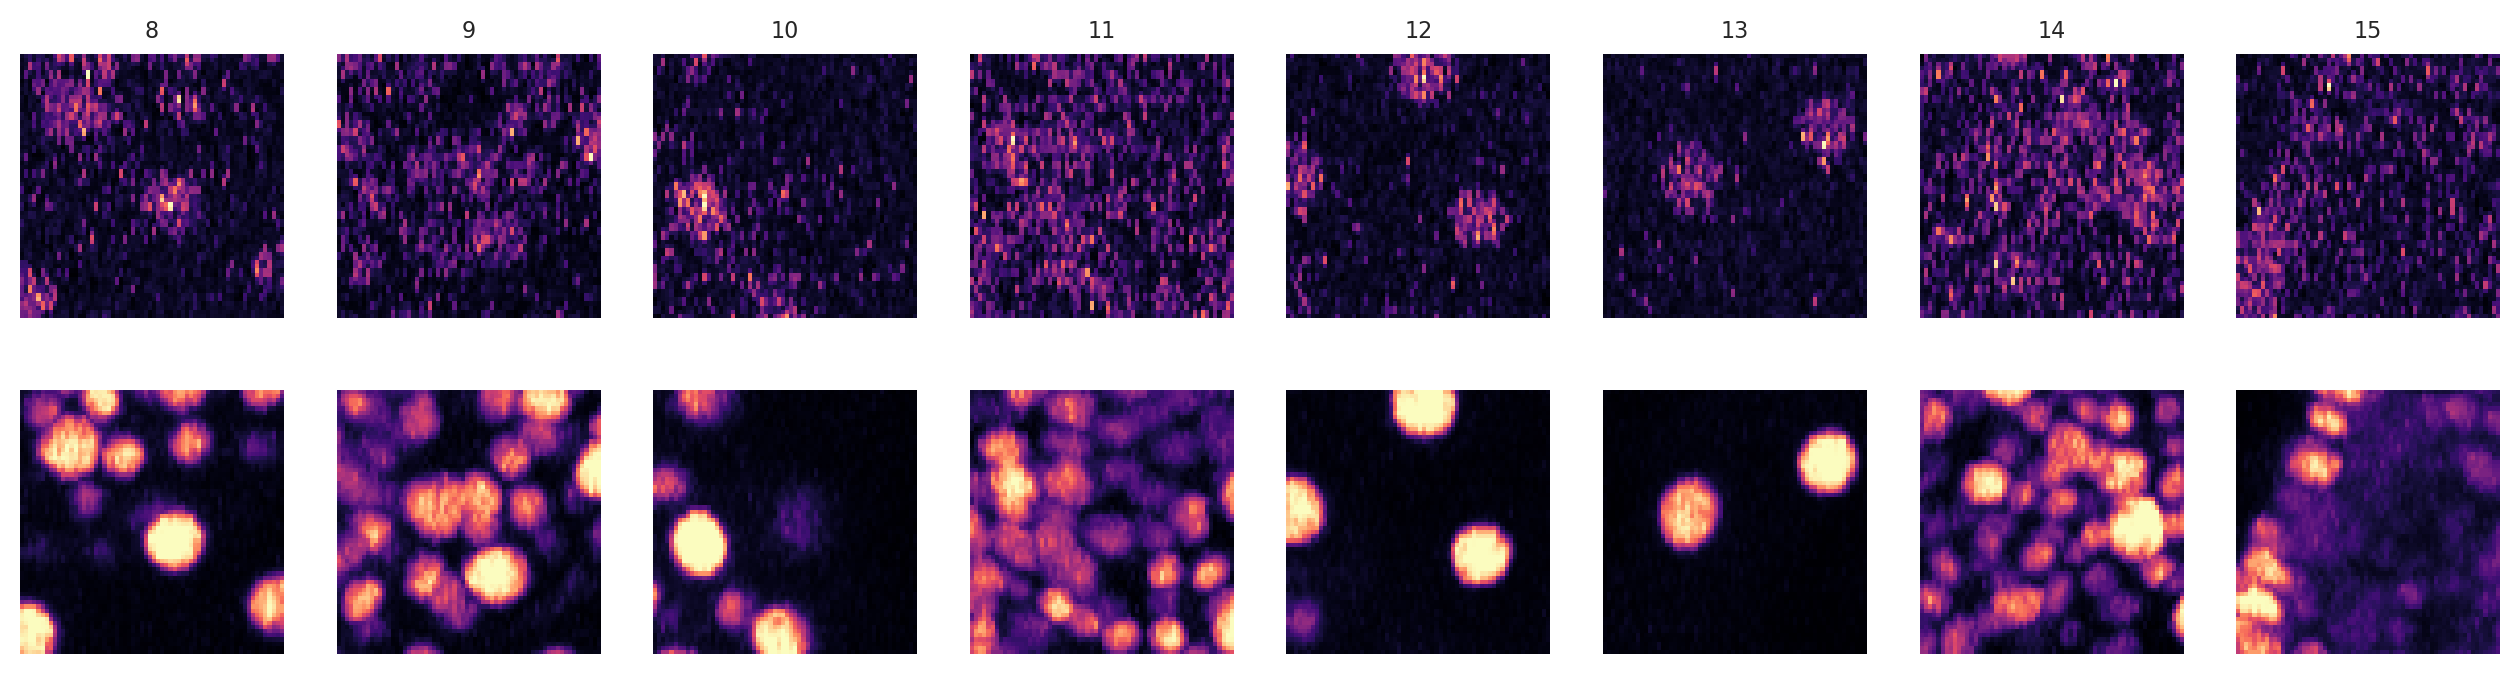

In [7]:


for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;



In [8]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

In [9]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 922
number of validation images:	 102
image size (3D):		 (16, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


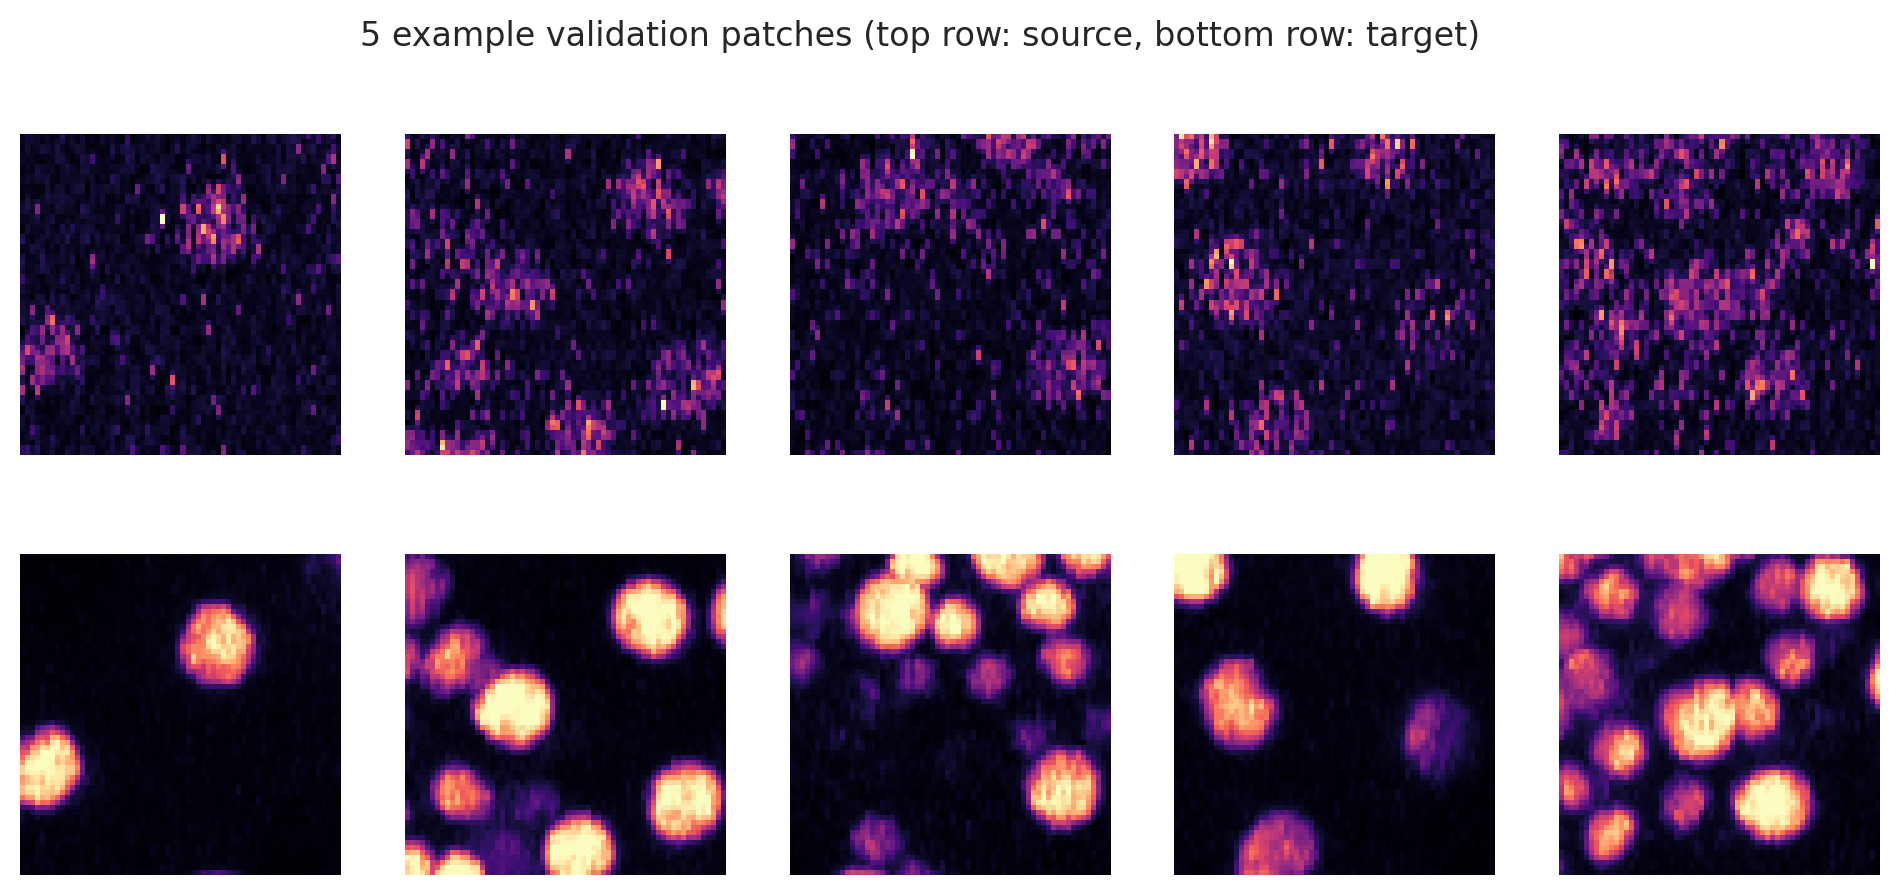

In [10]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

In [11]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=400)
print(config)
vars(config)

Config(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=1, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=True, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='linear', unet_input_shape=(None, None, None, 1), train_loss='mae', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=16, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0})


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [12]:
model = CARE(config, 'my_model', basedir='models')

In [13]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x74ff53cb12d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x74ff53cb12d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda x: K.mean(x, axis=-1)

Match 1:
lambda x: x

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals

InvalidArgumentError: image must be 3-dimensional[3,64,64,1] [Op:EncodePng]

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

In [ ]:
specimen = '0806_E6'
img_path, _ = ds.read_specimen(specimen, 'Nuclei', 'RawImages', verbose=1)
img_path_out = img_path.replace('.nii.gz', '_crop.nii.gz')

metadata, affine = imaging.load_metadata(img_path)
img = imaging.read_image(img_path, axes='XYZ', verbose=1)
crop = img[510:650, 250:360, 120:160] #
# imaging.save_nii(crop, img_path_out, affine=affine, verbose=1)

In [ ]:
model = CARE(config=None, name='my_model', basedir='models')


In [ ]:
restored = model.predict(crop, axes='XYZ', n_tiles=(1,2,2))